In [3]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Choose a fire

Fires aren't mapped onto MBTS or NIFC fire names, so the fireID that the FEDS algorithm generates is a number. If I am interested in a specific fire, I look at a late-season snapshot file that should contain that fire, and I figure out the ID from that. 

In [4]:
snap = fv.prep_gdf(date = '20191031PM',handle_multi=False,only_lf=True,area_lim=5)
snap.explore()

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


In [5]:
## Load up that fire 
fireID = '9987'
gdf = fv.load_large_fire(fireID)

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191024AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191024PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191025AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191025PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191026AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191026PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191027AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191027PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F9987_20191028AM', '/projects/shared-buckets/gsfc_landslides/FED

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


## Gridded FWI Products

There are a few gridded FWI products that exist. To see them all listed (plus a few more EIS datasets), we can look at the contents of this folder. In it there is a FWI-GEOS-5 with hourly resolution, one with daily resolution, and forecast datasets. 

In [4]:
s3.ls("s3://veda-data-store-staging/EIS/zarr/") # Gridded FWI products are stored here. 

['veda-data-store-staging/EIS/zarr/.zgroup',
 'veda-data-store-staging/EIS/zarr/FWI-GEOS-5-Hourly',
 'veda-data-store-staging/EIS/zarr/FWI.GEOS-5.zarr',
 'veda-data-store-staging/EIS/zarr/FWI_GPM_LATE_v5_Daily.zarr',
 'veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr',
 'veda-data-store-staging/EIS/zarr/OCO2_GEOS_L3CO2_day.zarr',
 'veda-data-store-staging/EIS/zarr/SPL3SMP.zarr',
 'veda-data-store-staging/EIS/zarr/gia']

We can read in the dataset we are most interested in. Here I read in the "daily" resolution product.

In [5]:
imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")
imerge.rio.write_crs("epsg:4326", inplace=True)
imerge.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
imerge

<xarray.Dataset>
Dimensions:           (time: 3250, lat: 1330, lon: 3600)
Coordinates:
  * lat               (lat) float64 -57.95 -57.85 -57.75 ... 74.75 74.85 74.95
  * lon               (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * time              (time) datetime64[ns] 2014-05-01 2014-05-02 ... 2023-03-24
    spatial_ref       int64 0
Data variables:
    GPM.LATE.v5_BUI   (time, lat, lon) float32 ...
    GPM.LATE.v5_DC    (time, lat, lon) float32 ...
    GPM.LATE.v5_DMC   (time, lat, lon) float32 ...
    GPM.LATE.v5_DSR   (time, lat, lon) float32 ...
    GPM.LATE.v5_FFMC  (time, lat, lon) float32 ...
    GPM.LATE.v5_FWI   (time, lat, lon) float32 ...
    GPM.LATE.v5_ISI   (time, lat, lon) float32 ...
Attributes: (12/46)
    Center:              NASA GISS / Columbia University
    Center::             center
    DCDryStartFactor:    5.0
    DCDryStartFactor::   DC number of days since precip mult factor for dry s...
    DCStart:             15.0
    DCStart::            DC starting value after wet winter
    ...                  ...
    snowCoverDaysCalc:   60.0
    snowCoverDaysCalc::  Number of days prior to spring over which to determi...
    startShutDays:       2.0
    startShutDays::      Number of previous days over which to consider start...
    tempThresh:          6.0
    tempThresh::         Temp thresh (C) to define start and end of winter

**Subset to a specific fire**

In [6]:
final_perimeter = max(gdf[gdf.t == max(gdf.t)].geometry) ## Get the final perimeter of a fire. 
lons = final_perimeter.envelope.exterior.coords.xy[0]
lats = final_perimeter.envelope.exterior.coords.xy[1]

img_clip = imerge.rio.clip_box(minx = min(lons), miny = min(lats), maxx=max(lons), maxy = max(lats), auto_expand= True) # Clip by space
img_clip = img_clip.sel(time = slice(min(gdf.t), max(gdf.t))).mean(dim = ["lat", "lon"]) ## Clip by time

img_clip

<xarray.Dataset>
Dimensions:           (time: 6)
Coordinates:
  * time              (time) datetime64[ns] 2019-10-24 2019-10-25 ... 2019-10-29
    spatial_ref       int64 0
Data variables:
    GPM.LATE.v5_BUI   (time) float32 484.3 488.1 491.6 493.7 496.2 498.6
    GPM.LATE.v5_DC    (time) float32 1.221e+03 1.227e+03 ... 1.239e+03 1.243e+03
    GPM.LATE.v5_DMC   (time) float32 441.9 445.9 449.5 451.6 454.1 456.6
    GPM.LATE.v5_DSR   (time) float32 43.04 29.63 29.2 67.31 24.06 38.05
    GPM.LATE.v5_FFMC  (time) float32 97.59 97.68 97.47 96.26 96.55 96.71
    GPM.LATE.v5_FWI   (time) float32 63.92 51.96 51.5 80.8 46.21 59.19
    GPM.LATE.v5_ISI   (time) float32 21.36 15.14 14.94 32.74 12.55 19.04

I also have a pre-written function for subsetting to a specific fire & merging the output. 

In [7]:
sub_imerge = fv.imerge_merge(fireID, year = "2019", path_region = "WesternUS", add_anomolies = False)
sub_imerge

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


(array('d', [-122.84407979187542, -122.60267863867738, -122.60267863867738, -122.84407979187542, -122.84407979187542]), array('d', [38.534916213631334, 38.534916213631334, 38.82353999355528, 38.82353999355528, 38.534916213631334]))


n_pixels  n_newpixels       farea     fperim   flinelen  duration  \
0       1466          282  280.802135  98.108137  45.155644       3.5   
1       1184          544  187.421563  64.983287  31.665822       3.0   
2        338          338   70.270270  38.070108  33.909390       0.0   
3        640           29  113.878165  50.282419   4.244982       2.5   
4        611          108  112.017163  50.033462  14.498416       2.0   
5        456           50   87.192550  43.891569  11.919409       1.0   
6        503           47   91.962610  45.590540   8.320518       1.5   
7        406           68   80.196451  42.282303  16.776737       0.5   
8       1682          216  328.046566  96.826439  30.774894       4.0   
9       1702           20  329.019411  95.929187   3.301761       4.5   
10      1766           64  336.180950  97.193723   8.023394       5.0   
11      1791           25  336.853082  96.803466   4.014153       5.5   

      pixden    meanFRP                   t  \
0   5.220758  25.320177 2019-10-27 12:00:00   
1   6.317309  38.425441 2019-10-27 00:00:00   
2   4.810000  36.312811 2019-10-24 00:00:00   
3   5.620041  72.725517 2019-10-26 12:00:00   
4   5.454521   5.148981 2019-10-26 00:00:00   
5   5.229805   3.479200 2019-10-25 00:00:00   
6   5.469614  49.576170 2019-10-25 12:00:00   
7   5.062568  14.043235 2019-10-24 12:00:00   
8   5.127321   5.607361 2019-10-28 00:00:00   
9   5.172947  23.774500 2019-10-28 12:00:00   
10  5.253123   5.620156 2019-10-29 00:00:00   
11  5.316858  21.868400 2019-10-29 12:00:00   

                                             geometry         lon        lat  \
0   POLYGON ((-122.81710 38.76604, -122.81710 38.7... -122.719815  38.696418   
1   POLYGON ((-122.81716 38.76588, -122.81711 38.7... -122.735554  38.728194   
2   POLYGON ((-122.82081 38.73546, -122.81725 38.7... -122.761216  38.753575   
3   POLYGON ((-122.81954 38.75747, -122.81954 38.7... -122.750142  38.758082   
4   POLYGON ((-122.81953 38.75731, -122.81954 38.7... -122.751402  38.758507   
5   POLYGON ((-122.81921 38.75355, -122.81924 38.7... -122.763663  38.758232   
6   POLYGON ((-122.81924 38.75373, -122.81953 38.7... -122.761565  38.759738   
7   POLYGON ((-122.81737 38.74534, -122.81921 38.7... -122.763658  38.754596   
8   POLYGON ((-122.81710 38.76605, -122.81708 38.7... -122.715676  38.682686   
9   POLYGON ((-122.81708 38.76610, -122.81703 38.7... -122.715521  38.682490   
10  POLYGON ((-122.81703 38.76619, -122.81702 38.7... -122.713865  38.683399   
11  POLYGON ((-122.81702 38.76620, -122.81702 38.7... -122.713717  38.683462   

   fireID  GPM.LATE.v5_BUI  GPM.LATE.v5_DC  GPM.LATE.v5_DMC  GPM.LATE.v5_DSR  \
0    9987              NaN             NaN              NaN              NaN   
1    9987       493.698853     1235.621216       451.551361        67.311501   
2    9987       484.263153     1221.052490       441.903198        43.043644   
3    9987              NaN             NaN              NaN              NaN   
4    9987       491.643890     1232.206177       449.464020        29.196070   
5    9987       488.121216     1226.772339       445.860321        29.625044   
6    9987              NaN             NaN              NaN              NaN   
7    9987              NaN             NaN              NaN              NaN   
8    9987       496.166626     1239.443237       454.088013        24.055107   
9    9987              NaN             NaN              NaN              NaN   
10   9987       498.644501     1243.243408       456.639252        38.052490   
11   9987              NaN             NaN              NaN              NaN   

    GPM.LATE.v5_FFMC  GPM.LATE.v5_FWI  GPM.LATE.v5_ISI  
0                NaN              NaN              NaN  
1          96.263023        80.802963        32.735844  
2          97.592751        63.917141        21.357096  
3                NaN              NaN              NaN  
4          97.470146        51.503559        14.941766  
5          97.6844

## Look up weather station FWI for fires

In [8]:
## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


In [9]:
## Get Fire of interest lat and lon 

foi = gdf
foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
foi = foi.iloc[0] # First element

## Look for closest station
st_cls = fv.closest(st_dict, foi)

## Get station Data
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

## Merge with fire data

full_fr = fv.fr_st_merge(gdf, st, sub = True)
full_fr = full_fr.sort_values(by = ["t"])

**Diagnisitc Station Plotting**

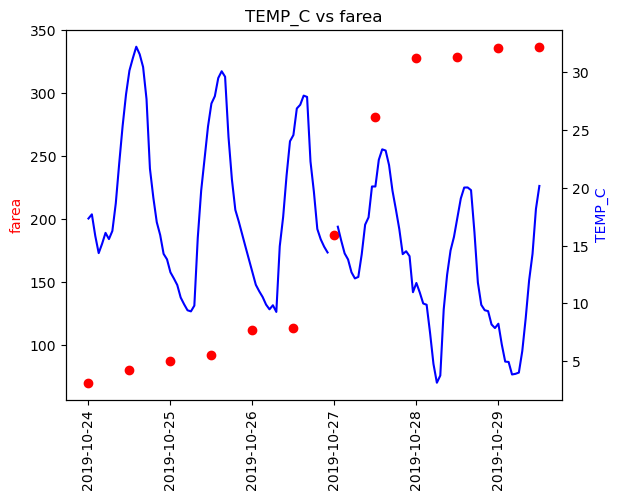

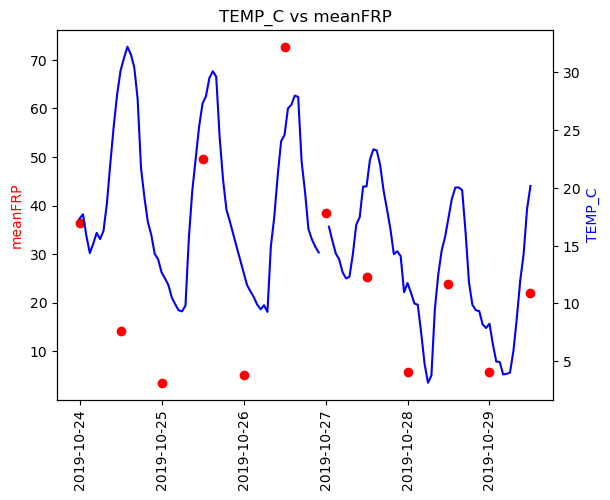

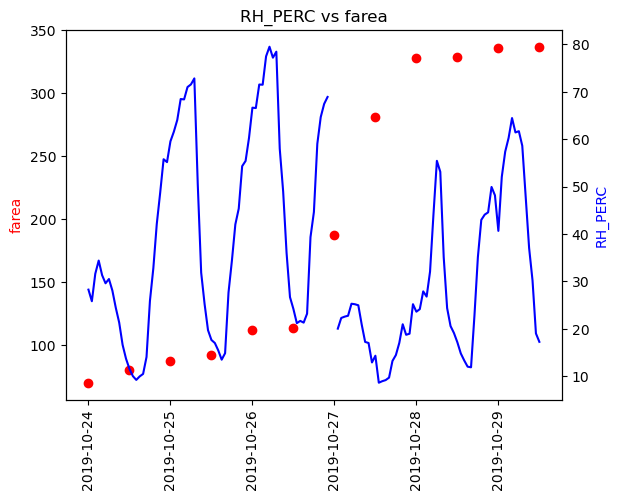

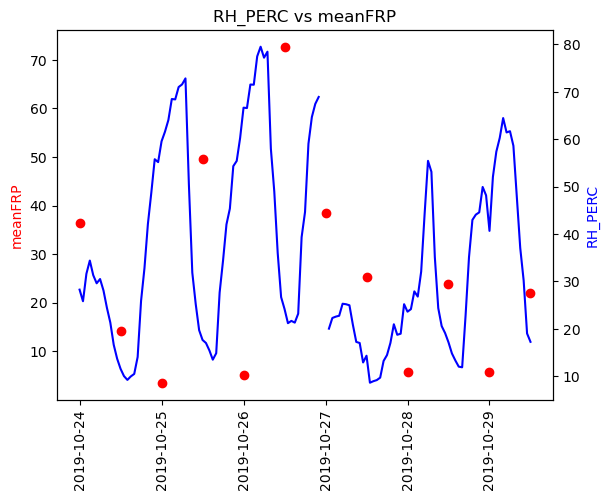

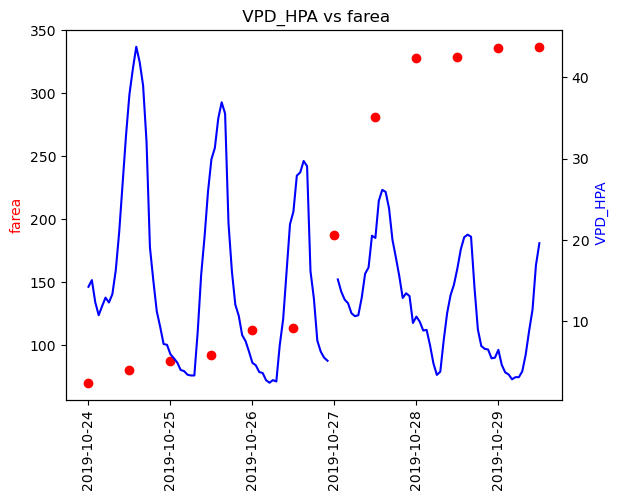

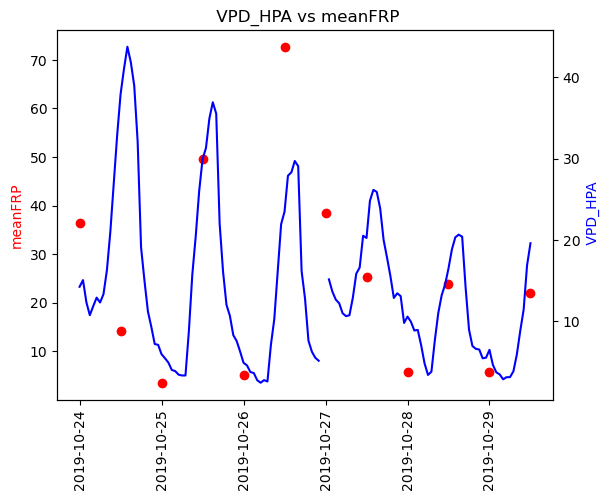

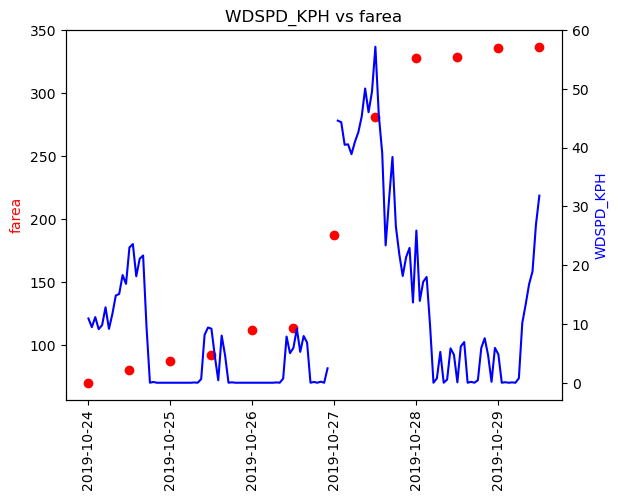

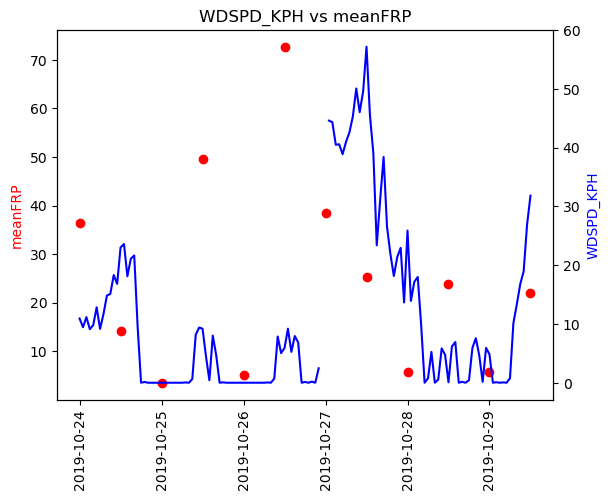

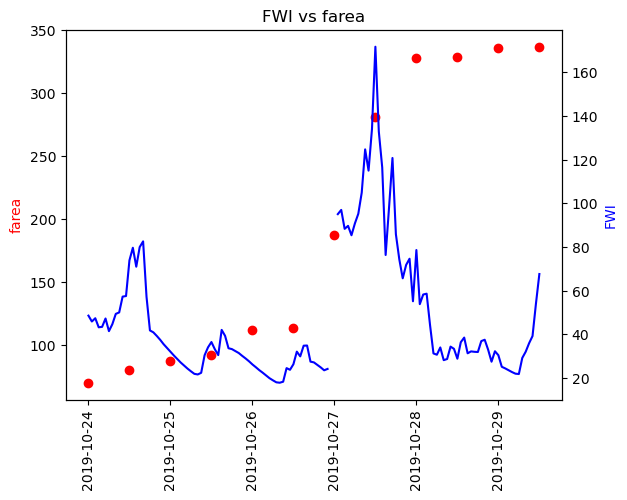

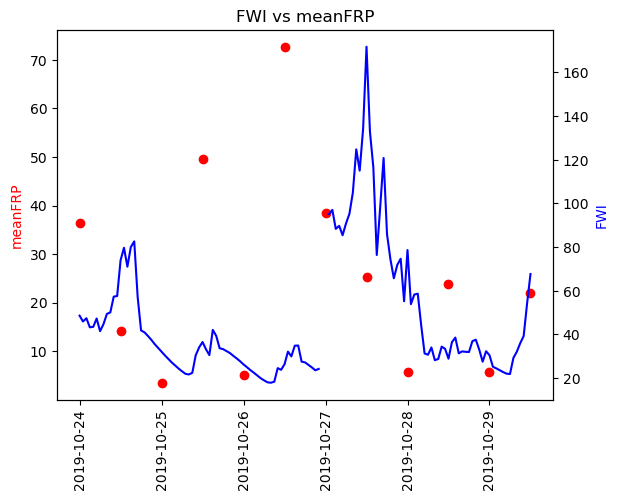

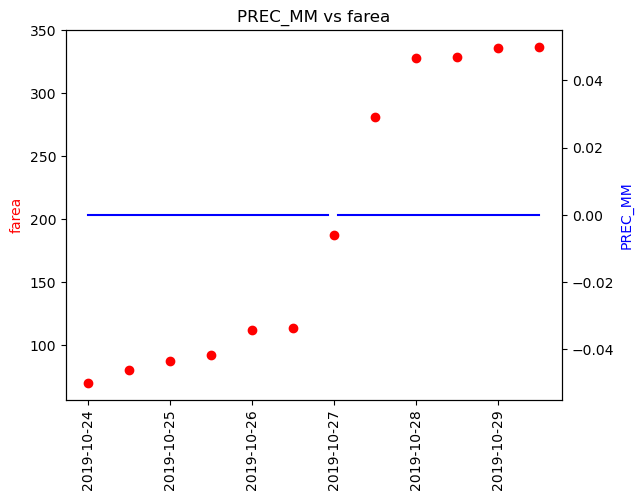

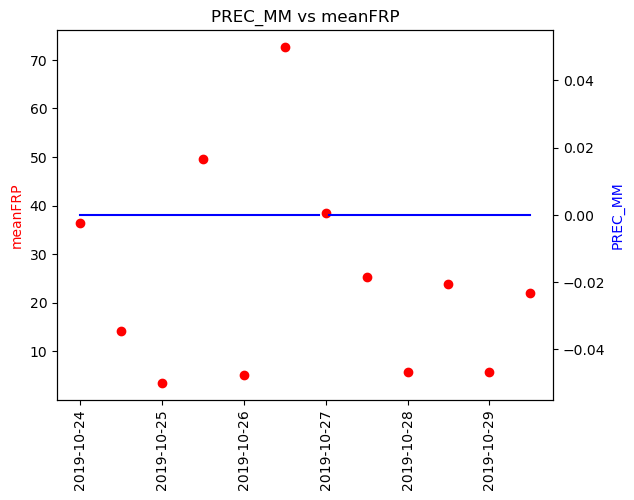

In [13]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']  ## Station Data Columns to Plot
fire = [ 'farea','meanFRP',] ## FEDS columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()